# Proof of Concept - Air Pollution Derivatives

<img src="https://www.populationeducation.org/sites/default/files/people_riding_bikes_in_smog.jpg",width=600,height=600>

## Motivation

Millions of people who live in urban areas are victims of severe air pollution. The degree of contamination is determined by measuring the so called criteria air pollutants (see for example the [US Environmental Protection Agency](https://www.epa.gov/criteria-air-pollutants)):

- Ground-level Ozone ($O_3$)
- Particulate Matter ($PM_{2.5}$ and $PM_{10}$)
- Carbon Monoxide ($CO$)
- Lead ($Pb$)
- Sulfur Dioxide ($SO_2$)
- Nitrogen Dioxide ($NO_2$)

The primary concerns in this context are the population health effects, but when ambient air pollution reach extreme levels, the day-to-day activity in the city is directly adffected. This may also lead to significant financial losses. We already use derivatives contracts such as futures and options for risk management in financial markets. There is also a well functioning market for managing risk arising from non-financial sources, such as weather. Temperature based weather derivatives have been used by the energy industry, the travel industry, and in agriculture for decades.  

**Can we introduce a new class of derivatives to manage risk arising from extreme air pollution? How can these instruments be used?** 

## Measuring and communicating degree of air pollution - Air Quality Index (AQI)

The criteria air pollutants are measured on the scales micrograms per cubic meter ($\mu g /m^3$), parts per million (ppm) and parts per billion (ppb). Countries have differents guidelines and tresholds, but the US Environmental Protection Agency **Air Quality Index (AQI)** is well know globally. The particulate matter pollutants $PM_{2.5}$ and $PM_{10}$ are some of the most severe treaths to human health, we will focus on these below.

![title](Air quality index - Wikipedia.png)

https://en.wikipedia.org/wiki/Air_quality_index

## Air pollution derivatives

This section describes how we can define index futures and european options on these futures based on the publicly 
available AQI data

### Traditional weather derivatives

[The CME weather derivatives market](http://www.cmegroup.com/trading/weather/) offers trade in futures contracts based on temperature indices, snow fall, percipitation, and more. The contracts are written for locations mainly in North America, Australia, Japan, and Europe. CME also lists plain vanilla European call and put options on these futures. We will have a closer look at one of the temperature based derivatives, as this will be used as a template for the air pollution contracts.  

For a given time period $[T_1, T_2]$, a cooling-degree index (CDD) is calculated to measure the need for cooling. The CDD is the cumulative amount of degrees above a pre specified base level:

\begin{equation}
CDD(T_1, T_2) = \sum_{t=T_1}^{T_2} max\{T_t - Base,0\}
\end{equation}

where $T_t$ is the mean temperature for day $t$, and the base level is typically $18^o C$/ $65^o F$. By taking a position in a CDD future, the holder of the contract swaps a fixed level of the index against the floating CDD. The change in market value for the position will be proportional to the development in the CDD, scaled up by the contract unit size. For example will a unit size of USD 20 per contract change the vale of the future by USD 20 for every unit change in the CDD index. The contracts can cover periods such as weeks,  months or seasons.

### The Pollution Alert Score (PAS) and PAS index futures

**Introducing the PAS:** When we evaluate an air quality measurement, we check if a criteria air pollutant is registered above a pre specified limit, such as the "Hazardous" 300 level on the AQI scale. If this is the case, we calculate the severity of the breach and assign a Pollution Alert Score (PAS). For the time period $[T_1, T_2]$, the cumulative Pollution Alert Score is given by:

\begin{equation}
PAS(T_1, T_2) = \sum_{t=T_1}^{T_2} max\{AQI_t - 300,0\}
\end{equation}

The period may be split up in hourly or daily measurements, we use daily data below. A PAS 300 Index Futures contract can now be specified with the following information, using PM2.5 levels in Beijing as an example:

| Contract specifications   | Example                            |
|---------------------------|------------------------------------|
| Location                  | Beijing                            |
| Pollutant                 | PM2.5                              |
| Contract type             | PAS 300 Index Future               |
| Period                    | February-18                        |
| Contract unit             | USD 1 times the PAS 300  Index       |
| Minimum price fluctuation | 1 index point (= USD 1 per contract) |

## Air quality data

In [7]:
# load R-packages and source functions for calculating AQI and PAS
library(data.table)
library(ggplot2)
source('calc_aqi_pas.R')
options(repr.plot.width = 6, repr.plot.height = 4)

In [2]:
# the US Embassy data
url <- 'http://www.stateair.net/web/assets/historical/'
bei <- c('Beijing_2017_HourlyPM25_created20170803.csv', 'Beijing_2016_HourlyPM25_created20170201.csv',
        'Beijing_2015_HourlyPM25_created20160201.csv', 'Beijing_2014_HourlyPM25_created20150203.csv',
        'Beijing_2013_HourlyPM2.5_created20140325.csv', 'Beijing_2012_HourlyPM2.5_created20140325.csv',
        'Beijing_2011_HourlyPM25_created20140709.csv', 'Beijing_2010_HourlyPM25_created20140709.csv',
        'Beijing_2009_HourlyPM25_created20140709.csv', 'Beijing_2008_HourlyPM2.5_created20140325.csv')

In [10]:
# import data from 2012-2015
beijing <- rbindlist(lapply(paste0(url, '1/', bei[3:6]), fread, skip = 3))

In [18]:
# quick and dirty, drop missing values -999
beijing <- subset(beijing, Value != -999)

# fix date and subset
beijing$Date <- as.Date(paste(beijing$Year, beijing$Month, beijing$Day, sep = "-"))
beijing <- beijing[, c('Date', 'Year', 'Month', 'Day', 'Hour', 'Value'), with=F]

# aggregate to daily data and add month
bd <- beijing[, .(Value=mean(Value), Year=mean(Year)), by = Date]
bd$Month <- month(bd$Date)

# use the sourced function calc_aqi to convert concentration values to AQI
bd$AQI <- calc_aqi(bd$Value)$AQI

Below, we will model both the PM2.5 measurements and related AQI scores with an Orstein-Uhlenbeck model with a seasonal
deterministic component. Lets us first fit a basic seasonal model to the PM2.5 data 

In [16]:
# first basic trend model for PM2.5 concentration
bd$d <- seq_along(bd$Date)
season <- lm(bd$Value ~ cos( 2*pi*bd$d / 365 ))
bd$season <- predict(season, data.frame(bd$d))

# first basic trend model for PM2.5 AQI
aqi_season <- lm(bd$AQI ~ cos( 2*pi*bd$d / 365 ))
bd$aqi_season <- predict(aqi_season, data.frame(bd$d))

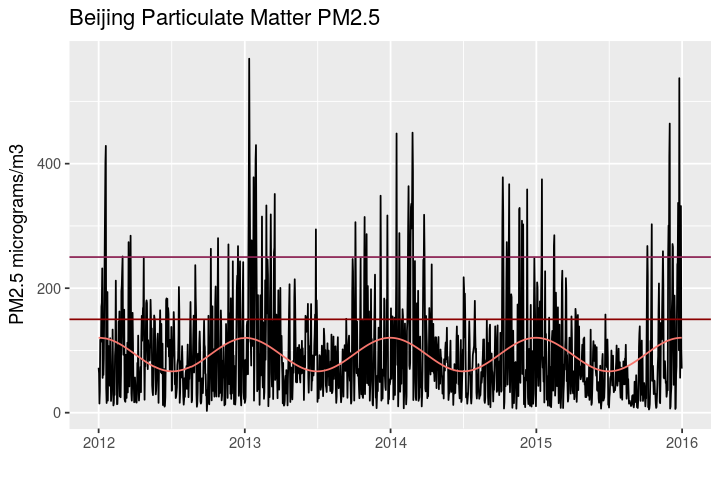

In [13]:
# PM2.5 plot with trend function and PM2.5 limits quivalent to 200 and 300 AQI
ggplot(bd, aes(x = Date)) + 
  geom_line(aes(y = Value)) + 
  geom_line(aes(y = season, colour = 'season')) + xlab("") + ylab("PM2.5 micrograms/m3") +
  theme(legend.position="none") + ggtitle("Beijing Particulate Matter PM2.5") +
  geom_hline(yintercept = 150, colour = "red4") +
  geom_hline(yintercept = 250, colour = "violetred4")

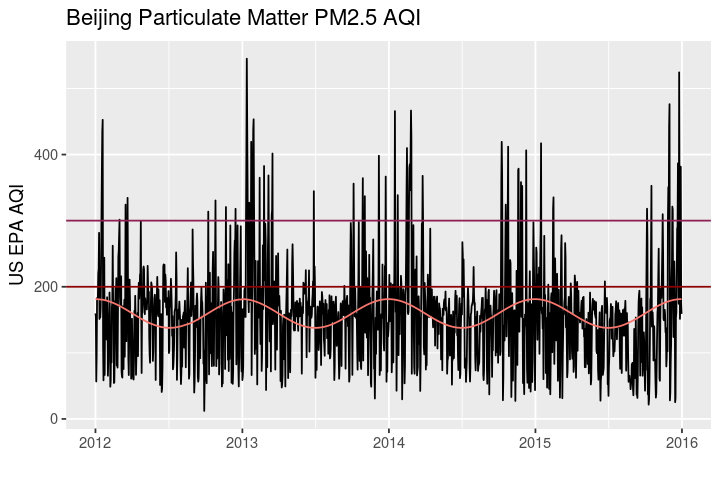

In [17]:
# AQI plot with trend function and 200 and 300 AQI limits
ggplot(bd, aes(x = Date)) + 
  geom_line(aes(y = AQI)) + 
  geom_line(aes(y = aqi_season, colour = 'aqi_season')) + xlab("") + ylab("US EPA AQI") +
  theme(legend.position="none") + ggtitle("Beijing Particulate Matter PM2.5 AQI") +
  geom_hline(yintercept = 200, colour = "red4") +
  geom_hline(yintercept = 300, colour = "violetred4")

We will model the underlying processes for the PAS index, but first we will apply simple burn analysis to investigate
historical contract values for the limits $AQI = 300$ and $AQI = 200$ for monthly contracts in the period 2012-2015.

## Burn analysis

## Modelling the PM2.5 concentration and the AQI

## Pricing PAS index futures

The time $t$ value of a long position in a futures contract settled at $T_2$:

\begin{equation}
e^{-r(T_2-t)}[PAS(T_1, T_2)-F_{PAS}(t, T_1, T_2)]
\end{equation}

## Pricing European options on PAS index futures